# Классификация методом kNN (k ближайших соседей)

## Описание задачи и информация о датасете
Маммография - самый эффективный метод диагностики рака груди, который доступен сегодня. Компьютерная диагностика (CAD) для характеристики маммографических образований как злокачественных или доброкачественных может помочь радиологам снизить частоту биопсии без увеличения количества ложноотрицательных результатов. Датасет содержит оценку BI-RADS, возраст пациента и три атрибута BI-RADS, вместе с  ground truth (severity) для доброкачественных и злокачественных новообразований, которые были идентифицированы на полноформатных цифровых маммограммах, собранных в университете Эрлангена — Нюрнберга с 2003 по 2006 год. Каждому экземпляру соответствует оценка BI-RADS в диапазоне от 1 (определенно безвредно) до 5 (что свидетельствует о злокачественности), которые были присвоены в процессе двойного обзора врачей.  Датасет можно использовать для прогнозирования степени тяжести образований (доброкачественная или злокачественная) на основе атрибутов, описывающих особенности образований, и возраста пациента.\
Распределение по классам: доброкачественные = 516, злокачественные = 445. \
Информация об атрибутах: всего 6 атрибутов (1 goal field, 1 непрогнозируемый, 4 прогнозируемых атрибута):\
BI-RADS assessment: от 1 до 5 (порядковый, непрогнозируемый!); Age: возраст пациента в годах (целочисленный); Shape: форма образований: круглая = 1, овальная, = 2 дольчатая = 3, неправильная = 4 (номинальный); Margin: края образований: ограниченные = 1, микролобулированные = 2, затемненные = 3, нечеткие = 4, спикулированные = 5(номинальный); Density: плотность образований: высокая = 1, изоплотность = 2, низкая = 3, жиросодержащая = 4 (порядковый); Severity: степень тяжести: доброкачественная = 0 или злокачественная = 1 (биноминальная, goal field!).\
Пропущенные значения:
BI-RADS assessment: 2; Age: 5; Shape: 31; Margin: 48; Density: 76; Severity: 0.\
Ссылка на датасет: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Загрузка и прочтение данных

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data'
data = pd.read_csv(url)

In [3]:
data.shape

(960, 6)

In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data

,5,67,3,5.1,3.1,1
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0
...,...,...,...,...,...,...
955,4,47,2,1,3,0
956,4,56,4,5,3,1
957,4,64,4,5,3,0
958,5,66,4,5,3,1


In [6]:
data.columns = ['BIRADS_assessment', 'Age', 'Shape', 'Margin', 'Density', 'Severity']

## Визуализация данных и описательная статистика

In [7]:
data.dtypes

BIRADS_assessment    object
Age                  object
Shape                object
Margin               object
Density              object
Severity              int64
dtype: object

In [8]:
data.head()

,BIRADS_assessment,Age,Shape,Margin,Density,Severity
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0


Для количественных признаков приведены количество значений, средние значения, стандартное отклонение, минимальное и макимальное значения, медиана и значения квартилей:

In [9]:
data.describe()

,Severity
count,960.000000
mean,0.462500
std,0.498852
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Для признаков типа object приведены количество значений, количество уникальных значений, самое распространенные значение и частота наиболее распространенного значения:

In [10]:
data.describe(include = ['object'])

,BIRADS_assessment,Age,Shape,Margin,Density
count,960,960,960,960,960
unique,8,74,5,6,5
top,4,59,4,1,3
freq,547,36,400,357,797


Диаграммы, которые показывают сколько раз номинальные признаки принимают те или иные значения:

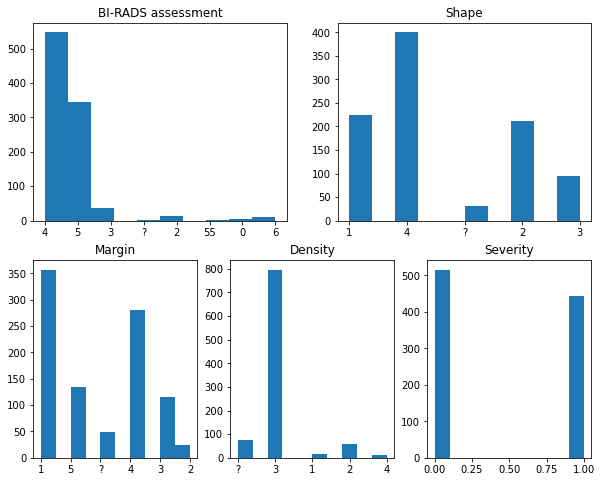

In [11]:
fig = plt.figure(figsize = (10, 8))
ax_1 = fig.add_subplot(2, 2, 1)
ax_2 = fig.add_subplot(2, 2, 2)
ax_3 = fig.add_subplot(2, 3, 4)
ax_4 = fig.add_subplot(2, 3, 5)
ax_5 = fig.add_subplot(2, 3, 6)
ax_1.hist(data.loc[:, "BIRADS_assessment"])
ax_1.set_title('BI-RADS assessment')
ax_2.hist(data.loc[:, "Shape"])
ax_2.set_title('Shape')
ax_3.hist(data.loc[:, "Margin"])
ax_3.set_title('Margin')
ax_4.hist(data.loc[:, "Density"])
ax_4.set_title('Density')
ax_5.hist(data.loc[:, "Severity"])
ax_5.set_title('Severity')
plt.show()

Диаграмма, которая показывает сколько пациентов того или иного возраста:

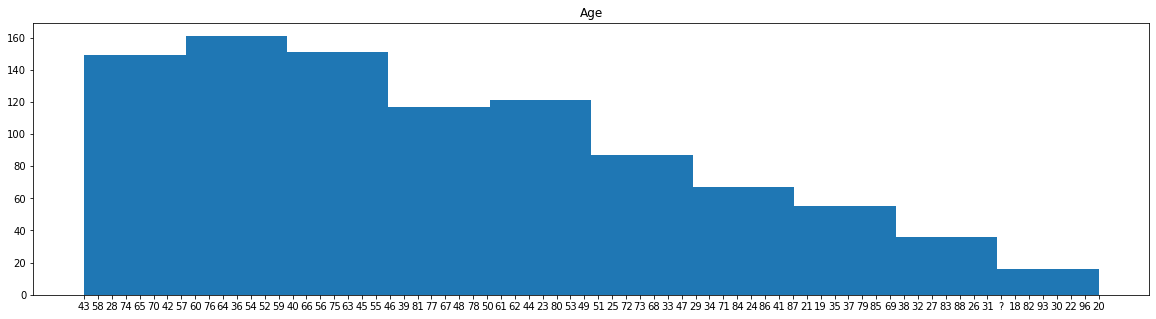

In [12]:
fig = plt.figure(figsize = (20, 5))
plt.hist(data.loc[:, "Age"])
plt.title('Age')
plt.show()

На основе диаграммы можно сделать вывод о том, что большинство пациентов имеет средний/пожилой возраст. Меньшинство имеет молодой или старческий возраст.

## Обработка пропущенных значений

Атрибут BI-RADS assessment непрогнозируемый, поэтому его можно исключить.

In [13]:
data = data.drop(['BIRADS_assessment'], axis=1)

In [14]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']

In [15]:
data.loc[data.Shape == "?", 'Shape'] = None
data.loc[data.Age == "?", 'Age'] = None
data.loc[data.Margin == "?", 'Margin'] = None
data.loc[data.Density == "?", 'Density'] = None

In [16]:
data.head()

,Age,Shape,Margin,Density,Severity
0,43,1,1,None,1
1,58,4,5,3,1
2,28,1,1,3,0
3,74,1,5,None,1
4,65,1,None,3,0


In [17]:
data['Shape'].unique()

array(['1', '4', None, '2', '3'], dtype=object)

In [18]:
data['Shape'].describe().top

'4'

In [19]:
data['Shape'] = data['Shape'].fillna('4')

In [20]:
data['Shape'].unique()

array(['1', '4', '2', '3'], dtype=object)

Для категориальных признаков пропущенные значения заполняем самым популярным значением в столбце (у признака Severity нет пропущенных значений, поэтому его не трогаем):

In [21]:
data_describe = data.describe(include = [object])
for c in categorical_columns:
    data[c] = data[c].fillna(data_describe[c]['top'])

In [22]:
data.head()

,Age,Shape,Margin,Density,Severity
0,43,1,1,3,1
1,58,4,5,3,1
2,28,1,1,3,0
3,74,1,5,3,1
4,65,1,1,3,0


## Бинаризация номинальных признаков

In [23]:
nonbinary_columns = ['Shape', 'Margin', 'Density']
binary_columns = ['Severity']

In [24]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])
print(data_nonbinary.columns)

Index(['Shape_1', 'Shape_2', 'Shape_3', 'Shape_4', 'Margin_1', 'Margin_2',
       'Margin_3', 'Margin_4', 'Margin_5', 'Density_1', 'Density_2',
       'Density_3', 'Density_4'],
      dtype='object')


## Нормализация

Атрибут Age является целочисленным, т.е количественным, поэтому приводим его к целочисленному типу и выполняем стандратизацию:

In [25]:
data_age = data['Age'].astype('int64')

In [26]:
data_age = (data_age - data_age.mean(axis = 0))/data_age.std(axis = 0)

In [27]:
data_age.describe()

count    9.600000e+02
mean     8.529057e-17
std      1.000000e+00
min     -2.595200e+00
25%     -7.263446e-01
50%      1.042579e-01
75%      7.272098e-01
max      2.803716e+00
Name: Age, dtype: float64

Соединяем все в одну таблицу:

In [28]:
data = pd.concat((data_age, data_nonbinary, data[binary_columns]), axis = 1)

In [29]:
data.describe()

,Age,Shape_1,Shape_2,Shape_3,Shape_4,Margin_1,Margin_2,Margin_3,Margin_4,Margin_5,Density_1,Density_2,Density_3,Density_4,Severity
count,9.600000e+02,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.00000,960.000000
mean,8.529057e-17,0.233333,0.219792,0.097917,0.448958,0.421875,0.025000,0.120833,0.291667,0.140625,0.016667,0.061458,0.909375,0.01250,0.462500
std,1.000000e+00,0.423173,0.414321,0.297357,0.497647,0.494116,0.156206,0.326103,0.454767,0.347816,0.128086,0.240294,0.287225,0.11116,0.498852
min,-2.595200e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,-7.263446e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000
50%,1.042579e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000
75%,7.272098e-01,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,1.000000
max,2.803716e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


Теперь можно построить корреляционную матрицу:

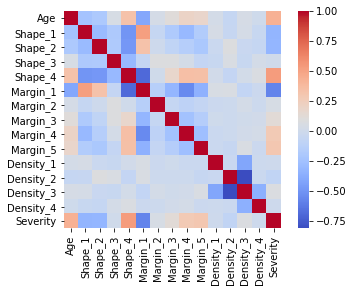

In [30]:
corr_mat = data.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

По изображению видно, что признаки практически не коррелируют между собой, так как являются независимыми.

## Разбиение данных на обучающуюю и тестовую выборки

Для предсказания будем использовать все входные признаки, кроме Severity, так как он является нашим goal field.

In [31]:
x = np.array(data.drop(['Severity'], axis=1))
y = np.array(data['Severity'])

In [32]:
print(x.shape)
print(y.shape)
N, d = x.shape

(960, 14)
(960,)


Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

720 240


## Классификация

### Нейронные сети (MLP - Multi Layer Perceptron)

#### Обучаем классификатор

In [34]:
from sklearn.neural_network import MLPClassifier

In [35]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,), random_state = 42)
mlp_model.fit(X_train, y_train)

C:\Users\proko\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

Проверяем качество классификатора

In [36]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

#### Ошибки на обучающей и тестовой выборках:

In [37]:
np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(0.17777777777777778, 0.20833333333333334)

In [38]:
from sklearn.metrics import accuracy_score

In [39]:
accuracy_score(y_train, y_train_pred)

0.8222222222222222

In [40]:
accuracy_score(y_test, y_test_pred)

0.7916666666666666

#### Подбор гиперпараметров:

Подберем оптимальное значение параметра регуляризации alpha

In [43]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

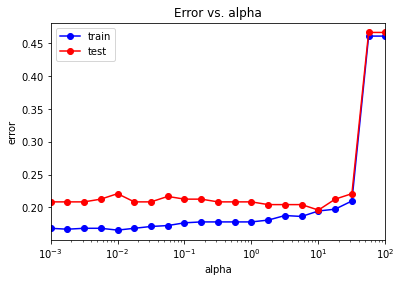

In [44]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

При alpha = 10 получаем оптимальное значение, т.к. ошибка на тестовой и тренировочной выборках совпадает.
При alpha > 10 ошибка резко увеличивается, что говорит о недообучении модели.

Рассмотрим как менялась метрика качества в зависимости от гиперпараметра alpha:

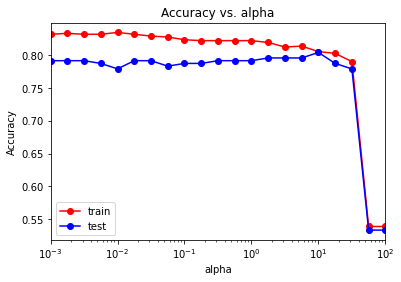

In [45]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

Минимальное значение ошибки:

In [46]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.16527777777777777 0.19583333333333333


Оптимальное значение alpha:

In [47]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[10.]


In [48]:
alpha_opt = alpha_opt[0]

#### Классификатор при найденном оптимальном значении alpha:

In [50]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100,), random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.19444444444444445
0.19583333333333333


In [51]:
accuracy_score(y_train, y_train_pred)

0.8055555555555556

In [52]:
accuracy_score(y_test, y_test_pred)

0.8041666666666667

Построим график зависимости ошибки от количества нейронов:

In [77]:
neuron_arr = np.linspace(10, 500, 10).astype(int)
test_error = []
train_error = []
test_acc = []
train_acc = []

for count in neuron_arr:
  mlp_model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(count,), max_iter=1000, random_state=42)
  mlp_model.fit(X_train, y_train)
  
  y_train_pred = mlp_model.predict(X_train)
  y_test_pred = mlp_model.predict(X_test)
  
  test_error.append(np.mean(y_test != y_test_pred))
  train_error.append(np.mean(y_train != y_train_pred))
  test_acc.append(accuracy_score(y_test, y_test_pred))
  train_acc.append(accuracy_score(y_train, y_train_pred))

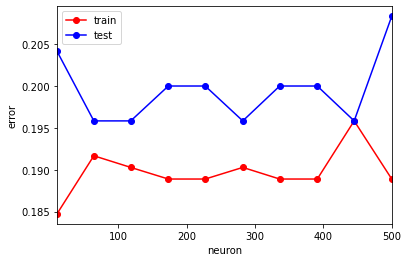

In [78]:
plt.plot(neuron_arr, train_error, 'r-o', label='train')
plt.plot(neuron_arr, test_error, 'b-o', label='test')
plt.xlim([np.min(neuron_arr), np.max(neuron_arr)])
plt.xlabel('neuron')
plt.ylabel('error')
plt.legend()

Подберем оптимальное значение числа нейронов:

In [83]:
neuron_arr = np.linspace(10, 500,10).astype(int)
test_err = []
train_err = []
train_acc = []
test_acc = []

for count in neuron_arr:
    mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (count,), max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

In [84]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.18472222222222223 0.19583333333333333


In [85]:
neuron_opt = neuron_arr[test_err == min_test_err]
print(neuron_opt)

[ 64 118 282 445]


In [86]:
neuron_opt = neuron_opt[0]

Обучим классификатор при оптимальном значении количества нейронов:

In [87]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuron_opt,), random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.19166666666666668
0.19583333333333333


In [88]:
accuracy_score(y_train, y_train_pred)

0.8083333333333333

In [89]:
accuracy_score(y_test, y_test_pred)

0.8041666666666667

Подбор количества нейронов совсем незначительно повысил точность на тренировочной выборке, а на тестовой значение точности вовсе не изменилось.

### Torch

In [ ]:
!pip3 install torch torchvision

  Using cached torch-1.10.0-cp38-cp38-win_amd64.whl (226.6 MB)


In [ ]:
import torch # библиотека нейронных сетей
import torch.nn as nn # модуль слоёв
import numpy as np

In [ ]:
model = nn.Sequential(
    nn.Linear(d, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)
model

Sequential(
  (0): Linear(in_features=14, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def train(model, X, y, loss_function, optimizer, batch_size=16, epochs=16):
    X_tensor = torch.Tensor(X)
    y_tensor = torch.LongTensor(y)
    model.train()
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for _ in range(epochs):
        losses = []
        for X_batch, y_batch in dataloader:
            logits = model(X_batch)
            loss = loss_function(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.data.numpy())
        print(np.mean(losses))

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train(model, X_train, y_train, loss_function, optimizer)

1.9416507
1.1819817
0.7001493
0.53774446
0.4876938
0.47042137
0.46057642
0.4571979
0.45439723
0.4506578
0.44912732
0.44833636
0.44748846
0.44812256
0.4440217
0.44331232


In [ ]:
from sklearn.metrics import  accuracy_score

In [ ]:
y_pred = model(torch.Tensor(X_test)).data.numpy().argmax(axis = 1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy = {accuracy}")

Accuracy = 0.7958333333333333


## Выводы:
- Наблюдается недообучение модели при alpha > 10;
- Переобучения не наблюдается;
- Подбор гиперпараметров помог повысить точность на тестовой выборке;
- Не слишком высокий процент точности предсказаний связан с недостаточно информативным датасетом для обнаружения образований.